# Recurrent Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Up until now, we have only seen feed forward neural networks. These networks do not have any idea of time. They are time-invariant.

$$ y_1 = f(x_1) $$

These network have been traditionally bad in predicting time series. Recurrent neural networks (RNNs) incorporate time by having loop connections, such that old input is fed again back into the network. Early Language models have used RNNs, such as language translation tools.

$$ y_1, h_1 = f(x_1, h_0) $$
$$ y_2, h_2 = f(x_2, h_1) $$

In a sense the network reuses past outputs as inputs to keep track of time.

In our example, we will analyse sentiment data. The goal is to predict, if it is a positive or negative sentence. The time series comes from the relation of the word *not* and feeling attributes.

In [2]:
train_data = {
  'good': True,
  'bad': False,
  'happy': True,
  'sad': False,
  'not good': False,
  'not bad': True,
  'not happy': False,
  'not sad': True,
  'very good': True,
  'very bad': False,
  'very happy': True,
  'very sad': False,
  'i am happy': True,
  'this is good': True,
  'i am bad': False,
  'this is bad': False,
  'i am sad': False,
  'this is sad': False,
  'i am not happy': False,
  'this is not good': False,
  'i am not bad': True,
  'this is not sad': True,
  'i am very happy': True,
  'this is very good': True,
  'i am very bad': False,
  'this is very sad': False,
  'this is very happy': True,
  'i am good not bad': True,
  'this is good not bad': True,
  'i am bad not good': False,
  'i am good and happy': True,
  'this is not good and not happy': False,
  'i am not at all good': False,
  'i am not at all bad': True,
  'i am not at all happy': False,
  'this is not at all sad': True,
  'this is not at all happy': False,
  'i am good right now': True,
  'i am bad right now': False,
  'this is bad right now': False,
  'i am sad right now': False,
  'i was good earlier': True,
  'i was happy earlier': True,
  'i was bad earlier': False,
  'i was sad earlier': False,
  'i am very bad right now': False,
  'this is very good right now': True,
  'this is very sad right now': False,
  'this was bad earlier': False,
  'this was very good earlier': True,
  'this was very bad earlier': False,
  'this was very happy earlier': True,
  'this was very sad earlier': False,
  'i was good and not bad earlier': True,
  'i was not good and not happy earlier': False,
  'i am not at all bad or sad right now': True,
  'i am not at all good or happy right now': False,
  'this was not happy and not good earlier': False,
}

test_data = {
  'this is happy': True,
  'i am good': True,
  'this is not happy': False,
  'i am not good': False,
  'this is not bad': True,
  'i am not sad': True,
  'i am very good': True,
  'this is very bad': False,
  'i am very sad': False,
  'this is bad not good': False,
  'this is good and happy': True,
  'i am not good and not happy': False,
  'i am not at all sad': True,
  'this is not at all good': False,
  'this is not at all bad': True,
  'this is good right now': True,
  'this is sad right now': False,
  'this is very bad right now': False,
  'this was good earlier': True,
  'i was not happy and not good earlier': False,
}

vocab = list(set([w for text in train_data.keys() for w in text.split(' ')]))
vocab_size = len(vocab)
word_to_idx = { w: i for i, w in enumerate(vocab) }
idx_to_word = { i: w for i, w in enumerate(vocab) }

print('Vocaublary size, unique words:', vocab_size)
print('Index of the word good:', word_to_idx['good'])
print('Word which has index 5:', idx_to_word[5])

Vocaublary size, unique words: 18
Index of the word good: 9
Word which has index 5: right


In [3]:
def one_hot(text):
    inputs = []
    for w in text.split(' '):
        v = np.zeros((vocab_size, 1))
        v[word_to_idx[w]] = 1
        inputs.append(v)
    return inputs

# We have three words, and in every word, exactly one element is 1 and the rest are 0
example = np.array(one_hot('i am good'))
print(example.shape)
print(example[1].flatten())

(3, 18, 1)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Looping Connection (Hidden State)

If you look into the documentation of for example [pytorch](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), you will see this formula to calculate the hidden state


$$h_t = \tanh(\mathbf{W_{xh}} * \mathbf{x_t} + \mathbf{W_{hh}} * \mathbf{h_{t-1}} + \mathbf{b_h}) $$


This formula basically tells you, the hidden state, depends on the current input and the hidden state from before. This hidden state is then used to calculate the result

$$ y_t = \mathbf{W_{hy}} * \mathbf{h_t} + \mathbf{b_y} $$


## Backward pass

How do we do gradient descent now? We do the same as always. We calculate the error, but now we have to take the order into account. 

1. We have to calculate the the derivative of the softmax function with respect to the loss function (negative log likelihood): $ \frac{\partial L}{\partial y} $
2. We calculate $ \frac{\partial L}{\partial W_{hy}} $ and $ \frac{\partial L}{\partial b_{y}} $
3. Calculcate $ \frac{\partial L}{\partial W_{hx}} $, $ \frac{\partial L}{\partial W_{hh}} $ and $ \frac{\partial L}{\partial b_{h}} $

## Graphical Representation

While formulas are fun, nothing beats a graphical representation.

$x$ is the input and $y$ the output of the cell

![RNN](images/rnn.png)

In [4]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim
        self.W_xh = np.random.randn(hidden_dim, input_dim) * 0.01
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_hy = np.random.randn(output_dim, hidden_dim) * 0.01
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_y = np.zeros((output_dim, 1))

    def forward(self, x):
        h_t = np.zeros((self.hidden_dim, 1))
        self.h_states = []

        for t in range(len(x)):
            h_t = np.tanh(self.W_xh @ x[t] + self.W_hh @ h_t + self.b_h)
            self.h_states.append(h_t)

        y = self.W_hy @ h_t + self.b_y
        probs = softmax(y)
        return probs

    def backward(self, x, dy, lr=2e-2):
        n = len(x)
        dW_xh, dW_hh = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh)
        db_h = np.zeros_like(self.b_h)

        # First we calculate the gradients of our output w.r.t. the loss
        db_y = dy
        dW_hy = dy @ self.h_states[n-1].T
        dh = (self.W_hy.T @ dy)

        # Backpropagate through time
        for t in reversed(range(n)):
            # Derivative of tanh
            temp = (1 - self.h_states[t] ** 2) * dh
            db_h += temp
            dW_hh += temp @ self.h_states[t - 1].T
            dW_xh += temp @ x[t].T
            dh = self.W_hh.T @ temp

        # Clip gradients to mitigate exploding gradients
        for dparam in [dW_xh, dW_hy, dW_hh, db_h, db_y]:
            np.clip(dparam, -1, 1, out=dparam)

        self.W_hh -= lr * dW_hh
        self.W_xh -= lr * dW_xh
        self.W_hy -= lr * dW_hy
        self.b_h -= lr * db_h
        self.b_y -= lr * db_y

In [5]:
def process(data, rnn, backprop):
    items = list(data.items())
    random.shuffle(items)

    loss = 0
    num_correct = 0

    for x, y in items:
        inputs = one_hot(x)
        target = int(y)
        probs = rnn.forward(inputs)
        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)
        if backprop:
            # Check out the softmax notebook for more details
            # If we derive the negative log likelihood loss function with respect to the softmax function, we get this neat formula
            probs[target] -= 1
            rnn.backward(inputs, probs)
    return loss, num_correct / len(data)

Text(0.5, 1.0, 'Test Accuracy')

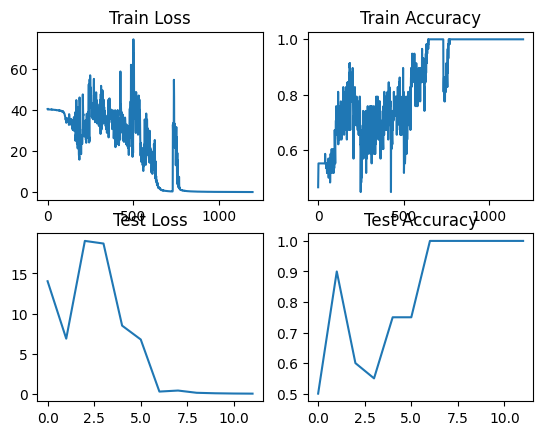

In [10]:
rnn = SimpleRNN(vocab_size, 64, 2)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in range(1200):
    train_loss, train_acc = process(train_data, rnn, backprop=True)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    if epoch % 100 == 99:
        test_loss, test_acc = process(test_data, rnn, backprop=False)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title('Train Loss')
axs[0, 1].plot(train_accuracies)
axs[0, 1].set_title('Train Accuracy')
axs[1, 0].plot(test_losses)
axs[1, 0].set_title('Test Loss')
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title('Test Accuracy')

In [11]:
print(np.argmax(rnn.forward(one_hot('this is happy'))))
print(np.argmax(rnn.forward(one_hot('this is not happy'))))

1
0


## Sources
* [rnn-from-scratch](https://github.com/vzhou842/rnn-from-scratch/tree/master)
* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
